In [161]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import sklearn
from scipy import stats
from subprocess import check_output
from sklearn.model_selection import train_test_split
import os
%matplotlib inline

# Methods to import data

### Methods To Import Event Data

In [162]:
'''
this function will take as an argument a file containing
the field index and description for every field in the data frames.
I will use this to create a template dataframe and to name the columns
because currently it is just using the first value as the column name
and it makes literally no sense at all.
'''
def shape_dataframe():
    #this file contains all the field descriptions
    field_descriptor_file_path = "csvFieldDescriptions.txt"
    
    #open the file and read it, adding each description to a list
    fields = open(field_descriptor_file_path, 'r')
    fieldInfo = []
    for field in fields:
        fieldInfo.append(field[2:].strip())
    return fieldInfo

In [163]:
'''
This function takes as an argument the number of subframes to include
where each 'subframe' is a pandas data frame containing play by play
data for a team for a year. It will then return those subframes
concatenated together into one main data frame. Subframes is preset to 50
'''
def create_dataframe(subframes=50):
    csv_paths = os.listdir('./csvFiles')#Get the paths of all of the CSV files
    column_info = shape_dataframe()#get the information on each field
    data = pd.DataFrame(columns=column_info)#create an empty data frame
    individual_data = []#create a list to hold the smaller frames
    del individual_data[:]#clear the list just in case I've already been using it

    #make all the dataframes
    df = pd.DataFrame(columns=column_info)
    for index, path in enumerate(csv_paths):#iterate over the list of paths
        #names=column_info is what names the columns
        df = pd.read_csv(str('./csvFiles/'+path), names=column_info)#read a file into a csv
        individual_data.append(df)#add it to the list
        if(index==50):#just so my computer doesn't die a slow death
            break
    data = pd.concat(individual_data)
    return data#, individual_data

### Method To Import Game Log Data

In [164]:
#reading in all the game logs and appending the dataframe accordingly
def get_gl_data():
    GLData = pd.DataFrame()
    gls = [] #to hold smaller frames
    del gls[:] #clear it to be sure
    glogpath = '../data/GameLogs/' #path to the game logs
    headPath = glogpath+'game_log_header.csv' #get the column info
    header = pd.read_csv(headPath) #import the column info
    colInfo = header.columns #store it for later use
    start_year = 1950 #define starting year. gonna use this in path
    end_year = 17 #also for path
    for logFolder in os.listdir(glogpath):
        try:#catching non int cases
            y1 = int(logFolder[2:4]) ##first two of start yyyy
            y2 = int(logFolder[2:6]) ##full start year
            y3 = int(str(y1)+logFolder[-2:]) #full end year
        except:
            continue
        #now open the folder if the start year is between the dates in the name
        if(start_year<y3):
            newPath = glogpath+logFolder
            files = os.listdir(newPath)#get all the logs in the folder
            for file in files:#now check each file to make sure it's the righ year
                year = int(file[2:6])#get year of file
                if(year>=start_year):#if it's within the range we want
                    full_path = glogpath+logFolder+'/'+file
                    gls.append(pd.read_csv(full_path, names=colInfo))
    GLData = pd.concat(gls)
    return GLData

# Creating Data Frames

In [165]:
EVdata = create_dataframe()

In [166]:
GLData = get_gl_data()

# Data Preprocessing

#### Pruning

In [150]:
#going to drop a lot of columns

#indexes for columns to drop. Honestly i just looked at the field descriptions
#and dropped mostly things like who was playing each position, where the ball 
#was hit, the names of people who contributed to the play, etc
ix = [12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 46, 47,
      49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
      67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80, 81, 82, 83, 84, 85, 86,
      87, 88, 89, 90, 91, 92, 93, 94, 95, 96
     ]

EVdatap = EVdata #copy data for pruned data

#Prune Columns
EVdatap = EVdatap.drop(EVdatap.columns[ix], axis=1) #prune columns

#Here, I am defining columns where if the value is null, the row should
#be dropped. These are mainly things like sacrifice hits or bunts
ixr = [21, 22, 29]

#drop rows with missing values that may skew batting averages
#Namely sacrifice hits and bunts
EVdatap = EVdatap.dropna(axis=1, subset=ixr)

#drop ixr columns too now that they've been used
EVdatap = EVdatap.drop(EVdatap.columns[ixr], axis=1)

#### Adding Features

In [152]:
#Adding in a bit more data on the team, date, game of day, and also field
EVdata['team'] = EVdata['game id'].astype(str).str[:3]#storing the team
EVdata['date'] = EVdata['game id'].astype(str).str[3:-1]#date
EVdata['game_of_day'] = EVdata['game id'].astype(str).str[-1:]#which game of the day it is

In [159]:
a = np.sum(EVdata.memory_usage())
b = np.sum(EVdatap.memory_usage())
print(b/a)#pruned data is this percentage of the memory usage of the unpruned

0.3527571708527888


# Analysis

In [160]:
data9 = EVdata.loc[data.inning==9]
data92 = data9[abs(data9['vis score']-data9['home score'])<2]#9th inning with two outs
x = data9['outs']
y = data9['RBI on play']
correlation = np.corrcoef(x, y)
EVdata["outOrHit"] = EVdata.apply(lambda row: 1 if 
                                (row["event type"]==2 or 
                                row["event type"]==3) else
                                2 if 
                                row["event type"]==20 else
                                3 if
                                row["event type"]==21 else
                                4 if
                                row["event type"]==22 else
                                5 if
                                row["event type"]==23
                                else None, axis=1)

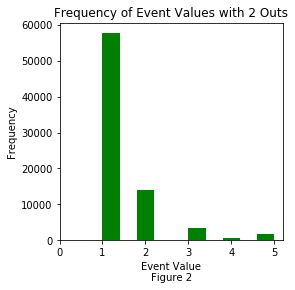

In [132]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(EVdata.loc[data.outs==2].outOrHit.dropna(), facecolor='green')
ax.set_xlabel("Event Value\nFigure 2")
ax.set_ylabel("Frequency")
ax.set_xticks(np.arange(6))
ax.set_title("Frequency of Event Values with 2 Outs")
fig.subplots_adjust(hspace=.5)
plt.show()

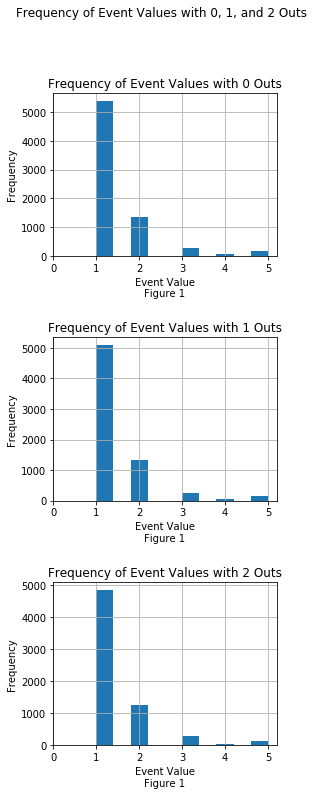

In [133]:
# Initialize figure and axis
fig, ax = plt.subplots(figsize=(4,12), nrows=3, ncols=1)
for i in data.loc[data.inning==9].outs.unique():
    EVdata.loc[(data.inning==9) & (data.outs==i)].outOrHit.hist(ax=ax[i])
    ax[i].set_xlabel("Event Value\nFigure 1")
    ax[i].set_ylabel("Frequency")
    ax[i].set_xticks(np.arange(6))
    ax[i].set_title("Frequency of Event Values with {0} Outs".format(i))
fig.subplots_adjust(hspace=.5)
plt.suptitle("Frequency of Event Values with 0, 1, and 2 Outs")
plt.show()

## Trying To Make Some Performance Metrics